# Islamophhobia Detection with mBERT using Keras and TensorFlow 2



In [1]:
!nvidia-smi

Fri Sep 18 02:19:42 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install tensorflow-gpu 

     |████████████████████████████████| 320.4MB 46kB/s 


In [3]:
!pip install --upgrade grpcio

Requirement already up-to-date: grpcio in /usr/local/lib/python3.6/dist-packages (1.32.0)


In [4]:
!pip install tqdm

In [5]:
!pip install bert-for-tf2

     |████████████████████████████████| 40kB 2.0MB/s 
  Created wheel for bert-for-tf2: filename=bert_for_tf2-0.14.6-cp36-none-any.whl size=30318 sha256=576e311e7c93b78cba314f113c868be4c601a482d4b77835b85d3080964464e3
  Stored in directory: /root/.cache/pip/wheels/07/a0/b4/75b0601ebaa41e517a797fe9cea119c789664c8408f8a74ae9
  Created wheel for py-params: filename=py_params-0.9.7-cp36-none-any.whl size=7304 sha256=55f3c72fc0fb05d84aae180e18935d23fd720e309089873fdde0adb1deabadbd
  Stored in directory: /root/.cache/pip/wheels/67/f5/19/b461849a50aefdf4bab47c4756596e82ee2118b8278e5a1980
  Created wheel for params-flow: filename=params_flow-0.8.2-cp36-none-any.whl size=19475 sha256=82c07e9840411d6205790f22f675a9d4ae9f7254a0dde91a8d634cece6a7f9c2
  Stored in directory: /root/.cache/pip/wheels/08/c8/7f/81c86b9ff2b86e2c477e3914175be03e679e596067dc630c06
Successfully built bert-for-tf2 py-params params-flow


In [6]:
!pip install googletrans

     |████████████████████████████████| 61kB 3.2MB/s 
     |████████████████████████████████| 962kB 9.8MB/s 
     |████████████████████████████████| 51kB 7.0MB/s 
     |████████████████████████████████| 61kB 7.5MB/s 
     |████████████████████████████████| 71kB 9.3MB/s 
     |████████████████████████████████| 102kB 10.3MB/s 
  Created wheel for googletrans: filename=googletrans-3.0.0-cp36-none-any.whl size=15736 sha256=d1f52595c8a8fc1b82fb0d2346fecedb6d9d17defdbf4c390e734aa40c46c3ab
  Stored in directory: /root/.cache/pip/wheels/28/1a/a7/eaf4d7a3417a0c65796c547cff4deb6d79c7d14c2abd29273e
  Created wheel for contextvars: filename=contextvars-2.4-cp36-none-any.whl size=7666 sha256=8eed12317580652d753212c4142fbc781d2a91fd731196a7199fc96bcce3b3a2
  Stored in directory: /root/.cache/pip/wheels/a5/7d/68/1ebae2668bda2228686e3c1cf16f2c2384cea6e9334ad5f6de
Successfully built googletrans contextvars


In [7]:
!pip install sentencepiece

     |████████████████████████████████| 1.1MB 3.4MB/s 


In [8]:
!pip install googletrans

In [9]:
import os
import math
import datetime

from tqdm import tqdm

import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras

import bert
from bert import BertModelLayer
from bert.loader import StockBertConfig, map_stock_config_to_params, load_stock_weights
from bert.tokenization.bert_tokenization import FullTokenizer

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import rc

from sklearn.metrics import confusion_matrix, classification_report

import re

# translator
import googletrans
from googletrans import Translator
translator = Translator()

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Data


In [10]:
# Hindi translated data
!gdown --id 1zJVv_Ldh5vhDmw2mJSrgMcKlLt1fWyBw --output data-task1.csv

# Hindi data
# !gdown --id 1EQRLvSUJn6VxFluTqNEGxXcV8_5OmCaW --output data-task3.csv

Downloading...
From: https://drive.google.com/uc?id=1zJVv_Ldh5vhDmw2mJSrgMcKlLt1fWyBw
To: /content/data-task1.csv
100% 797k/797k [00:00<00:00, 52.4MB/s]


In [11]:
orig_df = pd.read_csv('data-task1.csv', 
                   delimiter=',')
orig_df.columns = ['Text', 'Label']
orig_df.head(15)
orig_df["Text"] = orig_df["Text"].astype(str)
orig_df["Label"] = orig_df["Label"].astype(str)

In [12]:
orig_df.Text[3]


"'More than 500 students of Amin performed half-naked at the gate of the survey building. Pappu Yadav raised his voice"

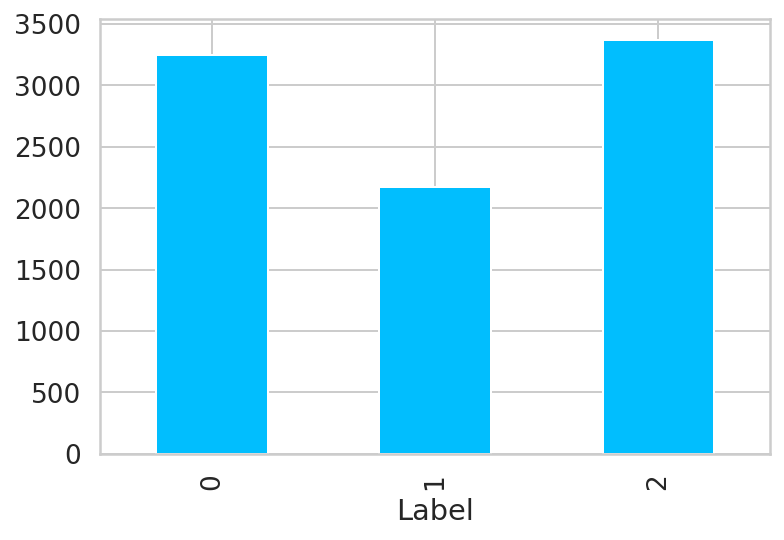

In [13]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(6,4))
orig_df.groupby('Label').Text.count().plot.bar(ylim=0)
plt.show()

In [14]:


# For entire dataset sentences for each labels 
orig_df.Label.value_counts()

2    3373
0    3245
1    2172
Name: Label, dtype: int64

In [15]:
#balancing data 
from collections import Counter
import numpy as np
def balanceClasses(xs, ys):
    item = {}
    new_ys = []
    new_xs = []
    #"""Undersample xs, ys to balance classes."""
    freqs = Counter(ys)
    # the most common class  is the maximum number we want for all classes
    max_allowable = (freqs.most_common()[0][1])
    
    for val in freqs.most_common(): # List
        nums = np.random.randint(1000)
        i = 1
        item[val[0]] = max_allowable - val[1]
        
        if item[val[0]] > 0:            
            while(item[val[0]] - i != 0): 
                nums = nums + 1
                if ys[nums] == val[0]:
                    i += 1
                    new_ys.append(ys[nums])
                    new_xs.append(xs[nums])
    return new_xs, new_ys

In [16]:
new_text, new_label = balanceClasses(orig_df['Text'], orig_df['Label'])

In [17]:
data_df = pd.DataFrame(new_text)
data_df.columns = ['Text']
data_df['Label'] = new_label
data_df = pd.concat([orig_df, data_df])

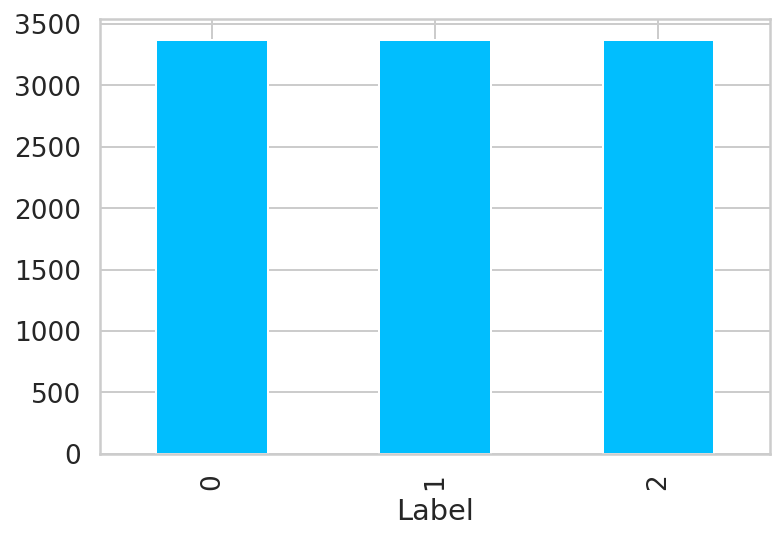

In [18]:
fig1 = plt.figure(figsize=(6,4))
data_df.groupby('Label').Text.count().plot.bar(ylim=0)
plt.show()

In [19]:
df = data_df

In [20]:
df.Label.value_counts()

2    3373
1    3372
0    3372
Name: Label, dtype: int64

In [21]:
df=df.sample(frac=1).reset_index(drop=True)
df

,Text,Label
0,"'To all those who have saluted,' Alaqum Aslam ...",1
1,'@Jalajisay for the last Congress is Lallu ji ...,0
2,"'Happy Birthday to the Respected Mother, Mars....",0
3,"Happy Islamic New Year, your approved bag Sarv...",1
4,'@ Pablo_neharu_da @ sunita_yadava 122 uare a ...,2
...,...,...
10112,'@ imMAK02 @ pbhushan1 you will also have to a...,2
10113,"'What is Jihadist, Radical and Radical Terror?...",2
10114,"'Which country has that Surat e Ilahi settled,...",1
10115,'@mysandeepmishra NRC is required. Find the ji...,2


Data Preprocessing

In [22]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.10, random_state=42)

In [23]:
df.head()

,Text,Label
0,"'To all those who have saluted,' Alaqum Aslam ...",1
1,'@Jalajisay for the last Congress is Lallu ji ...,0
2,"'Happy Birthday to the Respected Mother, Mars....",0
3,"Happy Islamic New Year, your approved bag Sarv...",1
4,'@ Pablo_neharu_da @ sunita_yadava 122 uare a ...,2


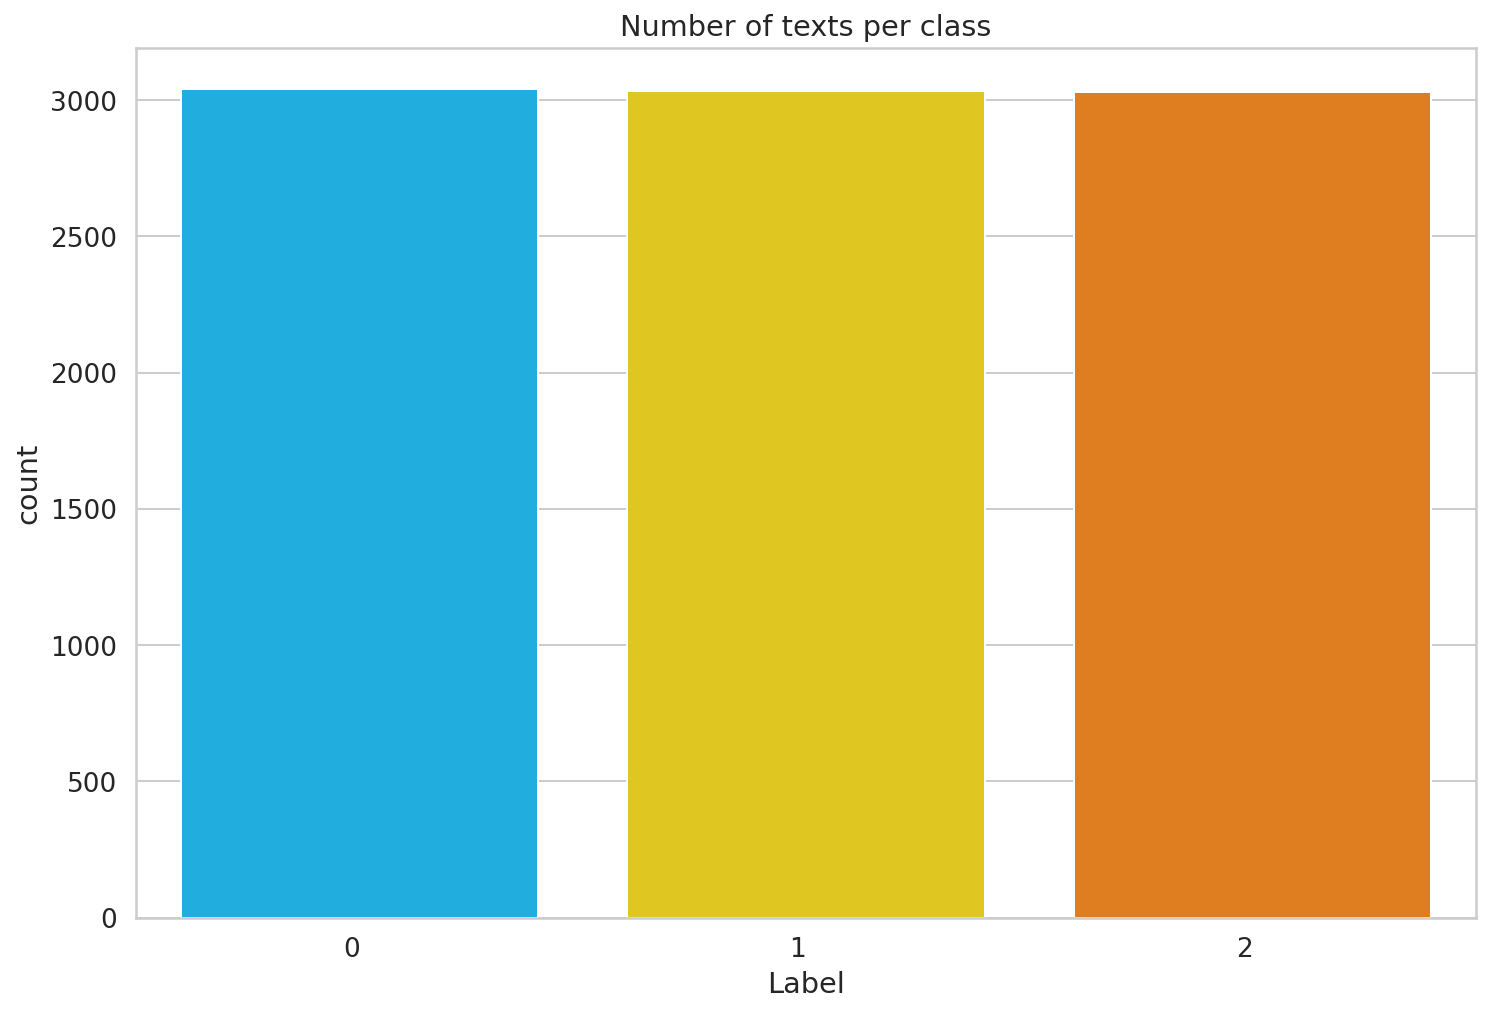

In [24]:
chart = sns.countplot(train.Label, palette=HAPPY_COLORS_PALETTE)
plt.title("Number of texts per class")
chart.set_xticklabels(chart.get_xticklabels(), horizontalalignment='right');

# Islamophhobia Detection with mBERT


In [25]:
!gdown --id 1ds0mgIfyRZ1vTdQCT4Q5EOxTFA1vH47a --output multi_cased_L-12_H-768_A-12.zip

Downloading...
From: https://drive.google.com/uc?id=1ds0mgIfyRZ1vTdQCT4Q5EOxTFA1vH47a
To: /content/multi_cased_L-12_H-768_A-12.zip
663MB [00:11, 59.1MB/s]


In [26]:
!unzip multi_cased_L-12_H-768_A-12

Archive:  multi_cased_L-12_H-768_A-12.zip
   creating: multi_cased_L-12_H-768_A-12/
  inflating: multi_cased_L-12_H-768_A-12/bert_model.ckpt.meta  
  inflating: multi_cased_L-12_H-768_A-12/bert_model.ckpt.data-00000-of-00001  
  inflating: multi_cased_L-12_H-768_A-12/vocab.txt  
  inflating: multi_cased_L-12_H-768_A-12/bert_model.ckpt.index  
  inflating: multi_cased_L-12_H-768_A-12/bert_config.json  


In [27]:
os.makedirs("model", exist_ok=True)

In [28]:
!mv multi_cased_L-12_H-768_A-12/ model

In [29]:
bert_model_name="multi_cased_L-12_H-768_A-12"

bert_ckpt_dir = os.path.join("model/", bert_model_name)
bert_ckpt_file = os.path.join(bert_ckpt_dir, "bert_model.ckpt")
bert_config_file = os.path.join(bert_ckpt_dir, "bert_config.json")

## Preprocessing

In [30]:
class IslamophobiaDetectionData:
  DATA_COLUMN = "Text"
  LABEL_COLUMN = "Label"

  def __init__(self, train, test, tokenizer: FullTokenizer, classes, max_seq_len=192):
    self.tokenizer = tokenizer
    self.max_seq_len = 0
    self.classes = classes
    
    ((self.train_x, self.train_y), (self.test_x, self.test_y)) = map(self._prepare, [train, test])

    print("max seq_len", self.max_seq_len)
    self.max_seq_len = min(self.max_seq_len, max_seq_len)
    self.train_x, self.test_x = map(self._pad, [self.train_x, self.test_x])

  def _prepare(self, df):
    x, y = [], []
    
    for _, row in tqdm(df.iterrows()):
      text, label = row[IslamophobiaDetectionData.DATA_COLUMN], row[IslamophobiaDetectionData.LABEL_COLUMN]
      tokens = self.tokenizer.tokenize(text)
      tokens = ["[CLS]"] + tokens + ["[SEP]"]
      token_ids = self.tokenizer.convert_tokens_to_ids(tokens)
      self.max_seq_len = max(self.max_seq_len, len(token_ids))
      x.append(token_ids)
      y.append(self.classes.index(label))

    return np.array(x), np.array(y)

  def _pad(self, ids):
    x = []
    for input_ids in ids:
      input_ids = input_ids[:min(len(input_ids), self.max_seq_len - 2)]
      input_ids = input_ids + [0] * (self.max_seq_len - len(input_ids))
      x.append(np.array(input_ids))
    return np.array(x)

In [31]:
tokenizer = FullTokenizer(vocab_file=os.path.join(bert_ckpt_dir, "vocab.txt"))

In [32]:
def create_model(max_seq_len, bert_ckpt_file):

  with tf.io.gfile.GFile(bert_config_file, "r") as reader:
      bc = StockBertConfig.from_json_string(reader.read())
      bert_params = map_stock_config_to_params(bc)
      bert_params.adapter_size = None
      bert = BertModelLayer.from_params(bert_params, name="bert")
        
  input_ids = keras.layers.Input(shape=(max_seq_len, ), dtype='int32', name="input_ids")
  bert_output = bert(input_ids)

  #print("bert shape", bert_output.shape)

  cls_out = keras.layers.Lambda(lambda seq: seq[:, 0, :])(bert_output)
  cls_out = keras.layers.Dropout(0.5)(cls_out)
  logits = keras.layers.Dense(units=768, activation="tanh")(cls_out)
  logits = keras.layers.Dropout(0.5)(logits)

  logits = keras.layers.Dense(units=len(classes), activation="softmax")(logits)


  model = keras.Model(inputs=input_ids, outputs=logits)
  model.build(input_shape=(None, max_seq_len))

  load_stock_weights(bert, bert_ckpt_file)
  
  model.compile(
  optimizer=keras.optimizers.Adam(1e-5),
  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")]
)
        
  return model

## Training

In [33]:
classes = train.Label.unique().tolist()

data = IslamophobiaDetectionData(train, test, tokenizer, classes, max_seq_len=128)

9105it [00:05, 1807.93it/s]
1012it [00:00, 1820.79it/s]


max seq_len 136


In [34]:
model = create_model(data.max_seq_len, bert_ckpt_file)

Done loading 196 BERT weights from: model/multi_cased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7fd2af76bf28> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights


In [35]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 128)]             0         
_________________________________________________________________
bert (BertModelLayer)        (None, 128, 768)          177261312 
_________________________________________________________________
lambda (Lambda)              (None, 768)               0         
_________________________________________________________________
dropout (Dropout)            (None, 768)               0         
_________________________________________________________________
dense (Dense)                (None, 768)               590592    
_________________________________________________________________
dropout_1 (Dropout)          (None, 768)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                

In [36]:


history = model.fit(
  x=data.train_x, 
  y=data.train_y,
  validation_split=0.1,
  batch_size=32,
  shuffle=True,
  epochs=5
)

Epoch 1/5
257/257 [==============================] - 211s 820ms/step - loss: 0.7655 - acc: 0.7737 - val_loss: 0.6369 - val_acc: 0.9111
Epoch 2/5
257/257 [==============================] - 205s 798ms/step - loss: 0.6279 - acc: 0.9221 - val_loss: 0.6179 - val_acc: 0.9330
Epoch 3/5
257/257 [==============================] - 205s 798ms/step - loss: 0.6100 - acc: 0.9403 - val_loss: 0.6098 - val_acc: 0.9396
Epoch 4/5
257/257 [==============================] - 205s 796ms/step - loss: 0.6048 - acc: 0.9458 - val_loss: 0.6073 - val_acc: 0.9429
Epoch 5/5
257/257 [==============================] - 204s 794ms/step - loss: 0.6009 - acc: 0.9495 - val_loss: 0.6027 - val_acc: 0.9484


## Evaluation

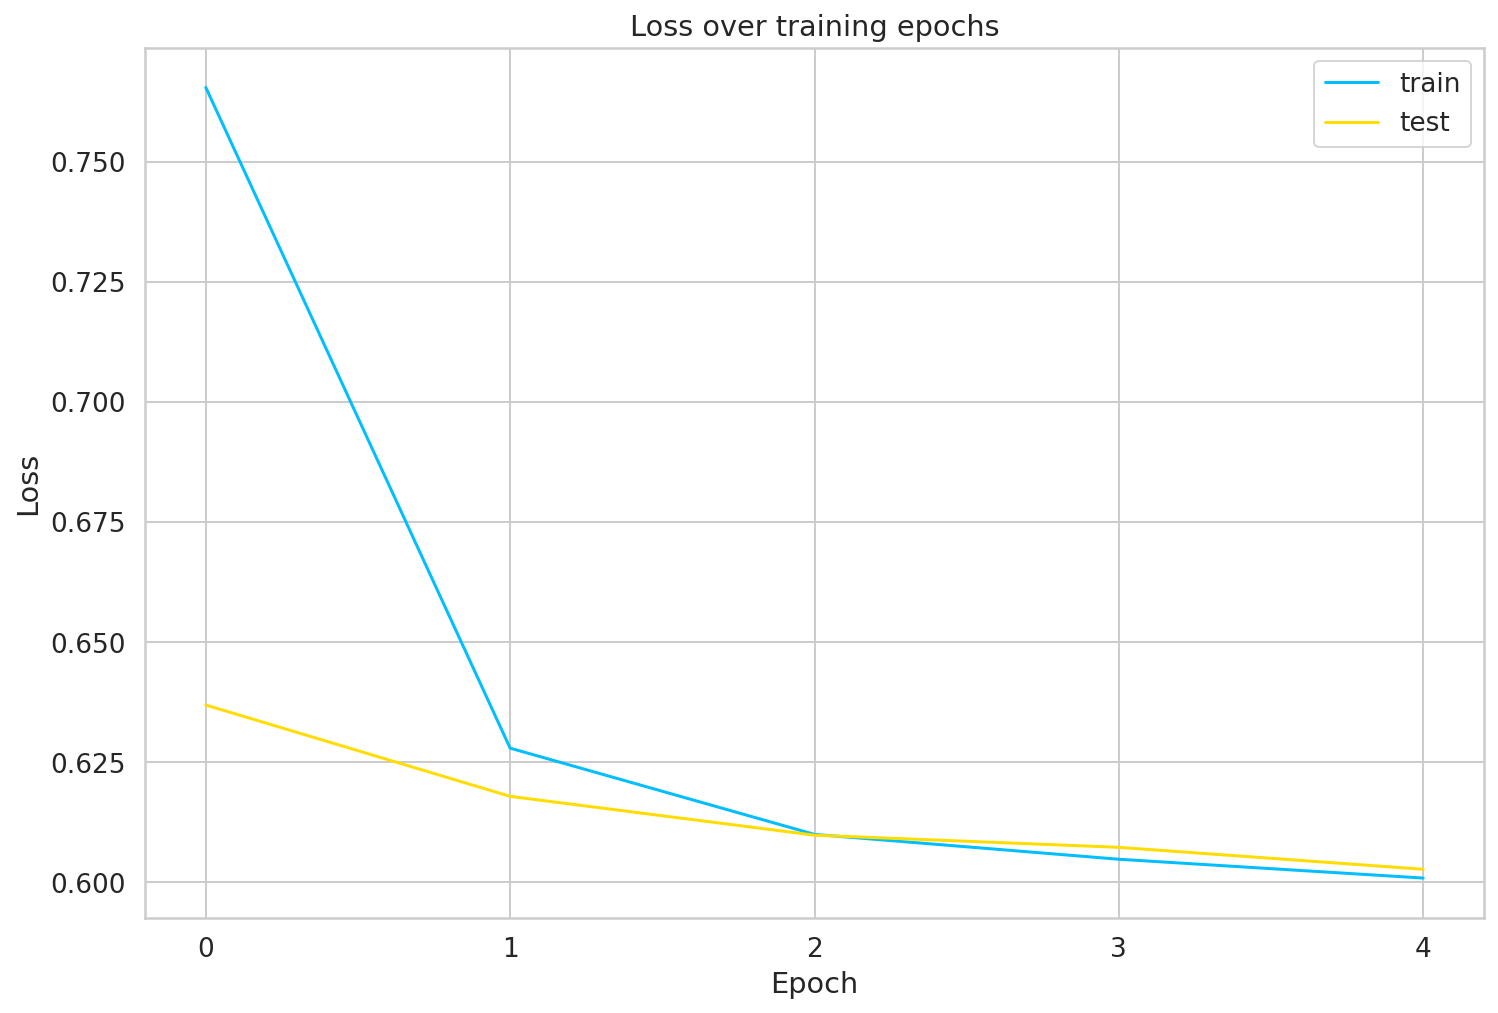

In [37]:
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Loss over training epochs')
plt.show();

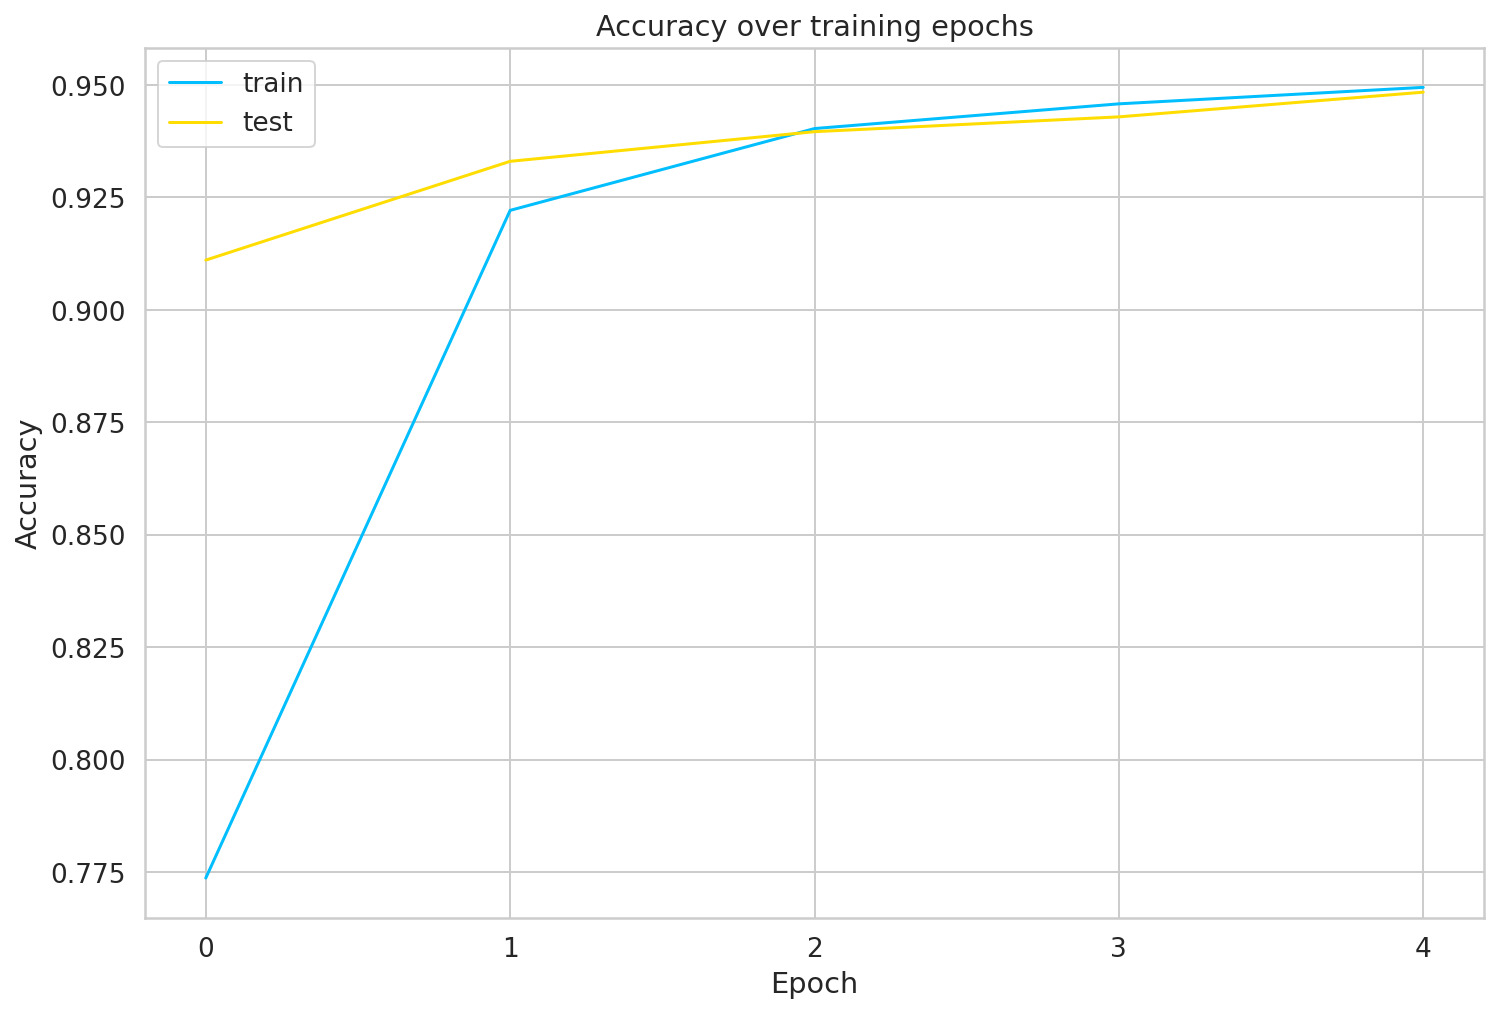

In [38]:
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax.plot(history.history['acc'])
ax.plot(history.history['val_acc'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Accuracy over training epochs')
plt.show();

In [39]:
_, train_acc = model.evaluate(data.train_x, data.train_y)
_, test_acc = model.evaluate(data.test_x, data.test_y)

print("train acc", train_acc)
print("test acc", test_acc)

32/32 [==============================] - 6s 173ms/step - loss: 0.6112 - acc: 0.9377
train acc 0.9596924781799316
test acc 0.937747061252594


In [40]:
y_pred = model.predict(data.test_x).argmax(axis=-1)

In [41]:
print(classification_report(data.test_y, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.97      0.94       337
           1       0.96      0.91      0.93       332
           2       0.95      0.94      0.94       343

    accuracy                           0.94      1012
   macro avg       0.94      0.94      0.94      1012
weighted avg       0.94      0.94      0.94      1012



In [42]:

cm = confusion_matrix(data.test_y, y_pred)
df_cm = pd.DataFrame(cm, index=classes, columns=classes)

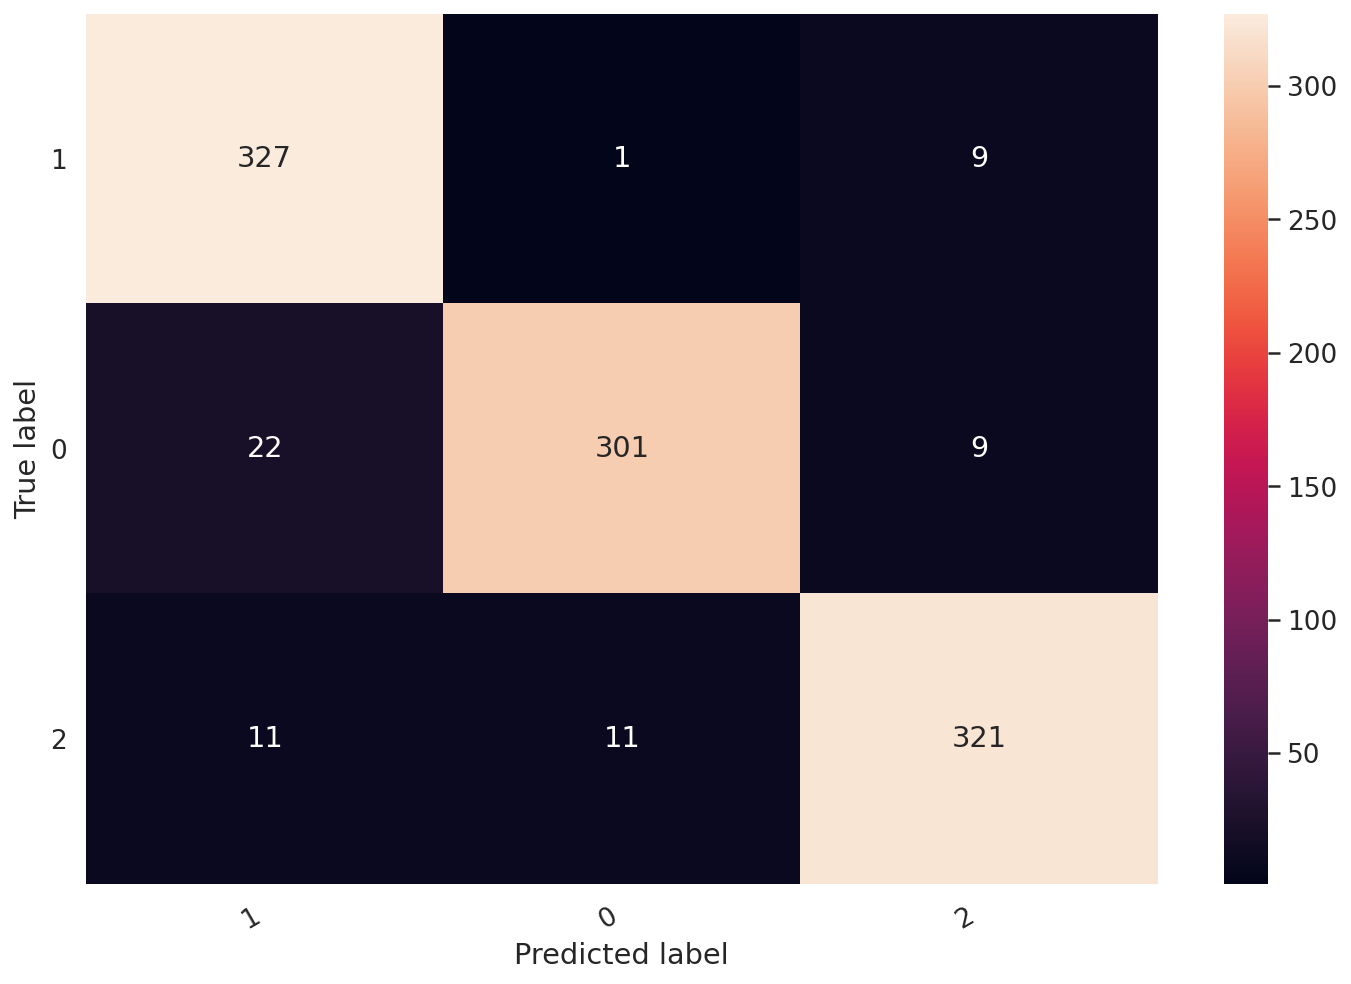

In [43]:
hmap = sns.heatmap(df_cm, annot=True, fmt="d")
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label');

# 10 Fold cross validation

In [44]:
import random
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

kFold = 10

#To get accuracy of the model for 10 different splits
scores = []
training_accuracy = []
testing_accuracy = []
print("mBERT: ")
for i in range(kFold):
    print('\n Fold ', i+1)
    print('')
    # Splitting data into test and train
    train, test = train_test_split(df, test_size=0.10, shuffle = True)

    classes = train.Label.unique().tolist()
    data = IslamophobiaDetectionData(train, test, tokenizer, classes, max_seq_len=128)
    model = create_model(data.max_seq_len, bert_ckpt_file)
    history = model.fit( x=data.train_x, y=data.train_y,validation_split=0.1,batch_size=32, shuffle=True,epochs=5)
    train_loss, train_acc = model.evaluate(data.train_x, data.train_y)
    test_loss, test_acc = model.evaluate(data.test_x, data.test_y)
    
    training_accuracy.append(train_acc)
    testing_accuracy.append(test_acc)

    y_pred = model.predict(data.test_x).argmax(axis=-1)

    scoreValue =accuracy_score(data.test_y, y_pred)
    scores.append(scoreValue)


199it [00:00, 1987.15it/s]

mBERT: 

 Fold  1



9105it [00:04, 1843.27it/s]
1012it [00:00, 1907.28it/s]


max seq_len 136
Done loading 196 BERT weights from: model/multi_cased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7fd23ae5db70> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Epoch 1/5
257/257 [==============================] - 208s 810ms/step - loss: 0.8273 - acc: 0.7060 - val_loss: 0.6586 - val_acc: 0.8891
Epoch 2/5
257/257 [==============================] - 207s 804ms/step - loss: 0.6390 - acc: 0.9109 - val_loss: 0.6419 - val_acc: 0.9056
Epoch 3/5
257/257 [==============================] - 207s 805ms/step - 

198it [00:00, 1979.59it/s]


 Fold  2



9105it [00:04, 1923.46it/s]
1012it [00:00, 1956.41it/s]


max seq_len 136
Done loading 196 BERT weights from: model/multi_cased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7fcf2acfbdd8> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Epoch 1/5
257/257 [==============================] - 211s 823ms/step - loss: 0.8022 - acc: 0.7257 - val_loss: 0.6461 - val_acc: 0.9023
Epoch 2/5
257/257 [==============================] - 208s 809ms/step - loss: 0.6230 - acc: 0.9268 - val_loss: 0.6455 - val_acc: 0.9034
Epoch 3/5
257/257 [==============================] - 207s 805ms/step - 

197it [00:00, 1964.26it/s]


 Fold  3



9105it [00:04, 1930.46it/s]
1012it [00:00, 1909.39it/s]


max seq_len 136
Done loading 196 BERT weights from: model/multi_cased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7fcf2efda5f8> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Epoch 1/5
257/257 [==============================] - 212s 826ms/step - loss: 0.8464 - acc: 0.6724 - val_loss: 0.6594 - val_acc: 0.8902
Epoch 2/5
257/257 [==============================] - 205s 799ms/step - loss: 0.6343 - acc: 0.9157 - val_loss: 0.6478 - val_acc: 0.9023
Epoch 3/5
257/257 [==============================] - 205s 796ms/step - 

174it [00:00, 1736.59it/s]


 Fold  4



9105it [00:04, 1901.58it/s]
1012it [00:00, 1893.21it/s]


max seq_len 136
Done loading 196 BERT weights from: model/multi_cased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7fd21a640320> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Epoch 1/5
257/257 [==============================] - 209s 814ms/step - loss: 0.8065 - acc: 0.7230 - val_loss: 0.6443 - val_acc: 0.9045
Epoch 2/5
257/257 [==============================] - 206s 801ms/step - loss: 0.6238 - acc: 0.9273 - val_loss: 0.6188 - val_acc: 0.9319
Epoch 3/5
257/257 [==============================] - 205s 799ms/step - 

176it [00:00, 1750.22it/s]


 Fold  5



9105it [00:04, 1932.94it/s]
1012it [00:00, 1878.19it/s]


max seq_len 136
Done loading 196 BERT weights from: model/multi_cased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7fcf2ca006d8> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Epoch 1/5
257/257 [==============================] - 209s 812ms/step - loss: 0.7468 - acc: 0.7958 - val_loss: 0.6218 - val_acc: 0.9286
Epoch 2/5
257/257 [==============================] - 206s 800ms/step - loss: 0.6204 - acc: 0.9301 - val_loss: 0.6167 - val_acc: 0.9352
Epoch 3/5
257/257 [==============================] - 206s 800ms/step - 

203it [00:00, 2026.46it/s]


 Fold  6



9105it [00:04, 1987.50it/s]
1012it [00:00, 1916.39it/s]


max seq_len 136
Done loading 196 BERT weights from: model/multi_cased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7fcf2c19d828> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Epoch 1/5
257/257 [==============================] - 208s 810ms/step - loss: 0.8268 - acc: 0.7044 - val_loss: 0.6409 - val_acc: 0.9067
Epoch 2/5
257/257 [==============================] - 203s 790ms/step - loss: 0.6218 - acc: 0.9279 - val_loss: 0.6182 - val_acc: 0.9319
Epoch 3/5
257/257 [==============================] - 202s 786ms/step - 

206it [00:00, 2052.01it/s]


 Fold  7



9105it [00:04, 2004.19it/s]
1012it [00:00, 1983.64it/s]


max seq_len 136
Done loading 196 BERT weights from: model/multi_cased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7fcc7fcb8828> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Epoch 1/5
257/257 [==============================] - 206s 803ms/step - loss: 0.7801 - acc: 0.7597 - val_loss: 0.6389 - val_acc: 0.9089
Epoch 2/5
257/257 [==============================] - 202s 785ms/step - loss: 0.6229 - acc: 0.9259 - val_loss: 0.6161 - val_acc: 0.9319
Epoch 3/5
257/257 [==============================] - 202s 788ms/step - 

208it [00:00, 2072.18it/s]


 Fold  8



9105it [00:04, 1994.26it/s]
1012it [00:00, 1919.95it/s]


max seq_len 136
Done loading 196 BERT weights from: model/multi_cased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7fcf2cff6f60> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Epoch 1/5
257/257 [==============================] - 205s 800ms/step - loss: 0.8463 - acc: 0.6784 - val_loss: 0.6441 - val_acc: 0.9045
Epoch 2/5
257/257 [==============================] - 202s 787ms/step - loss: 0.6284 - acc: 0.9219 - val_loss: 0.6426 - val_acc: 0.9078
Epoch 3/5
257/257 [==============================] - 202s 785ms/step - 

204it [00:00, 2034.04it/s]


 Fold  9



9105it [00:04, 1992.90it/s]
1012it [00:00, 1961.05it/s]


max seq_len 136
Done loading 196 BERT weights from: model/multi_cased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7fcf3651ee80> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Epoch 1/5
257/257 [==============================] - 204s 794ms/step - loss: 0.7931 - acc: 0.7399 - val_loss: 0.6543 - val_acc: 0.8935
Epoch 2/5
257/257 [==============================] - 202s 787ms/step - loss: 0.6365 - acc: 0.9137 - val_loss: 0.6327 - val_acc: 0.9155
Epoch 3/5
257/257 [==============================] - 202s 785ms/step - 

189it [00:00, 1881.31it/s]


 Fold  10



9105it [00:04, 2037.60it/s]
1012it [00:00, 1957.35it/s]


max seq_len 136
Done loading 196 BERT weights from: model/multi_cased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7fd23a6d9470> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Epoch 1/5
257/257 [==============================] - 205s 799ms/step - loss: 0.7571 - acc: 0.7818 - val_loss: 0.6169 - val_acc: 0.9330
Epoch 2/5
257/257 [==============================] - 202s 785ms/step - loss: 0.6177 - acc: 0.9336 - val_loss: 0.6121 - val_acc: 0.9363
Epoch 3/5
257/257 [==============================] - 201s 783ms/step - 

In [45]:

print('')
Mean_score = sum(scores) / len(scores)
print(f" Mean predict: {Mean_score}" )

mean_test = sum(testing_accuracy)/len(testing_accuracy)
print(f" Mean testing accuracy for 10 folds: {mean_test}" )


 Mean predict: 0.940810276679842
 Mean testing accuracy for 10 folds: 0.9408102810382843


In [46]:
translator = Translator()
sentences = []
# 1
hin_text =  "इसलाम सुंदर है"
print("Hindi: ", hin_text)

trans = translator.translate(hin_text, dest='en')
print('Translated:', trans.text)
print()
sentences.append(trans.text)

# 0
hin_text =  " समाज वादी  पार्टी  जिंदाबाद "
print("Hindi: ", hin_text)

trans = translator.translate(hin_text, dest='en')
print('Translated:', trans.text)
sentences.append(trans.text)

# 2
hin_text =  "'गाजा में दीवाली   की ढेरो बधाई मित्रो 😊💐  #IsraeliBombing 😂😂"
print("Hindi: ", hin_text)

trans = translator.translate(hin_text, dest='en')
print('Translated:', trans.text)
sentences.append(trans.text)

# 2
sentences.append( "Play our song now you asshole jehadi muslim")

# 0
sentences.append( "Rate this book as awful")


pred_tokens = map(tokenizer.tokenize, sentences)
pred_tokens = map(lambda tok: ["[CLS]"] + tok + ["[SEP]"], pred_tokens)
pred_token_ids = list(map(tokenizer.convert_tokens_to_ids, pred_tokens))

pred_token_ids = map(lambda tids: tids +[0]*(data.max_seq_len-len(tids)),pred_token_ids)
pred_token_ids = np.array(list(pred_token_ids))

predictions = model.predict(pred_token_ids).argmax(axis=-1)

for text, label in zip(sentences, predictions):
  print("text:", text, "\nLabel:", classes[label])
  print()

Hindi:  इसलाम सुंदर है
Translated: Islam is beautiful

Hindi:   समाज वादी  पार्टी  जिंदाबाद 
Translated: Samajwadi Party Zindabad
Hindi:  'गाजा में दीवाली   की ढेरो बधाई मित्रो 😊💐  #IsraeliBombing 😂😂
Translated: 'Happy Diwali greetings in Gaza Friends 😊💐 #IsraeliBombing 😂😂
text: Islam is beautiful 
Label: 1

text: Samajwadi Party Zindabad 
Label: 0

text: 'Happy Diwali greetings in Gaza Friends 😊💐 #IsraeliBombing 😂😂 
Label: 0

text: Play our song now you asshole jehadi muslim 
Label: 2

text: Rate this book as awful 
Label: 0



# Reference

1. Movie Reviews with bert-for-tf2 https://colab.research.google.com/drive/1esTDT7S7-31Uiwr8Hj1meV1aokeo8AYX?authuser=1